This is just to illustrate some nice ways of visualizing and inspecting the data within jupyter. Importantly, we note that `relative_orbit_number` changes along a track at the equator, so not great to use that to track/group bursts.

In [1]:
import sqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon

# Read Data

In [2]:
%time

# SQL must wrap the geometry in hex(st_asbinary(...))
sql = "SELECT * FROM burst_id_map;"
con = sqlite3.connect("S1_burstid_20220530/IW/sqlite/burst_map_IW_000001_375887.sqlite3")

df = gpd.GeoDataFrame.from_postgis(sql, con, geom_col="GEOMETRY")

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


In [3]:
df.head()

,OGC_FID,GEOMETRY,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass
0,1,"MULTIPOLYGON Z (((3.36758 0.75322 0.00000, 3.7...",1,IW1,1,2.301015,ASCENDING
1,2,"MULTIPOLYGON Z (((4.09178 0.97402 0.00000, 4.5...",1,IW2,1,3.133218,ASCENDING
2,3,"MULTIPOLYGON Z (((4.85545 1.19200 0.00000, 5.2...",1,IW3,1,4.211255,ASCENDING
3,4,"MULTIPOLYGON Z (((3.33269 0.92005 0.00000, 3.7...",2,IW1,1,5.059288,ASCENDING
4,5,"MULTIPOLYGON Z (((4.05690 1.14071 0.00000, 4.4...",2,IW2,1,5.891491,ASCENDING


# Sample Plots

We can plot an entire orbit/track (these two words are used interchangeably from my limited experience.

<AxesSubplot:>

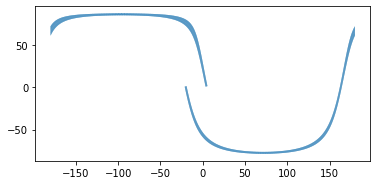

In [4]:
df[df.relative_orbit_number == 1].plot()

<AxesSubplot:>

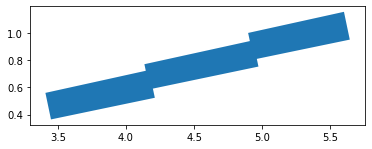

In [5]:
df[df.burst_id == 375886].plot()

Let's plot a bunch of bursts at the end of the dataframe and look at the overlap.

<AxesSubplot:>

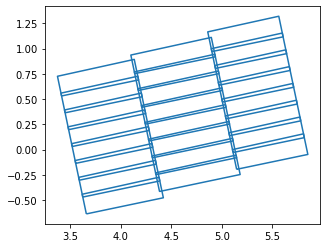

In [6]:
df[df.burst_id >= 375880].boundary.plot()

Note how the burst ids collected by 3 also have the subswaths `IW1` to `IW3`.

In [7]:
df[df.burst_id >= 375880].head()

,OGC_FID,GEOMETRY,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass
1127637,1127638,"MULTIPOLYGON Z (((3.66004 -0.63618 0.00000, 4....",375880,IW1,175,5903.750322,ASCENDING
1127638,1127639,"MULTIPOLYGON Z (((4.38445 -0.41412 0.00000, 4....",375880,IW2,175,5904.582525,ASCENDING
1127639,1127640,"MULTIPOLYGON Z (((5.14802 -0.19461 0.00000, 5....",375880,IW3,175,5905.660562,ASCENDING
1127640,1127641,"MULTIPOLYGON Z (((3.62496 -0.46936 0.00000, 4....",375881,IW1,175,5906.508595,ASCENDING
1127641,1127642,"MULTIPOLYGON Z (((4.34932 -0.24745 0.00000, 4....",375881,IW2,175,5907.340798,ASCENDING


We can single out an individual burst within a sub-swath via the `OGC_FID`.

<AxesSubplot:>

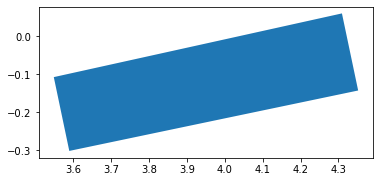

In [8]:
df[df.OGC_FID == 1127644].plot()

<AxesSubplot:>

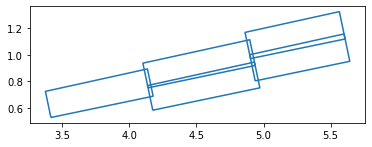

In [9]:
df[df.OGC_FID >= 1127657].boundary.plot()

<AxesSubplot:>

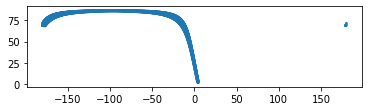

In [10]:
df[df.OGC_FID <= 2_000].boundary.plot()

The bursts get substantially warped at high latitudes.

<AxesSubplot:>

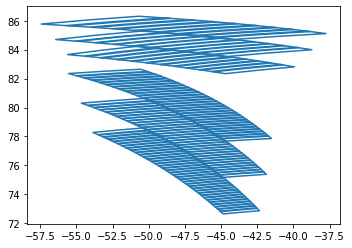

In [11]:
df[df.OGC_FID <= 10_000].boundary.cx[-50:-45, :].plot()

In [12]:
df[df.OGC_FID <= 10_000].cx[-50:-45, :].head()

,OGC_FID,GEOMETRY,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass
1500,1501,"MULTIPOLYGON Z (((-44.69493 82.33880 0.00000, ...",501,IW1,1,1381.437489,ASCENDING
1503,1504,"MULTIPOLYGON Z (((-45.51545 82.46574 0.00000, ...",502,IW1,1,1384.195762,ASCENDING
1506,1507,"MULTIPOLYGON Z (((-46.36318 82.59116 0.00000, ...",503,IW1,1,1386.954035,ASCENDING
1509,1510,"MULTIPOLYGON Z (((-47.23917 82.71499 0.00000, ...",504,IW1,1,1389.712308,ASCENDING
1512,1513,"MULTIPOLYGON Z (((-48.13909 82.83777 0.00000, ...",505,IW1,1,1392.470581,ASCENDING


<AxesSubplot:>

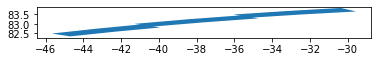

In [13]:
df[df.burst_id == 501].plot()

<AxesSubplot:>

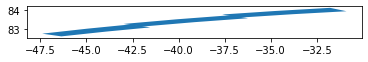

In [14]:
df[df.burst_id == 503].plot()

In [15]:
len(df[df.relative_orbit_number == 2].dissolve().geometry[0].geoms)

2

# Should we traverse relative orbits?

Answer: no. Why? Because of those issues at the equator noted above.

We will take a closer look at where these track/orbit discontinuities occur.

In [16]:
%%time
df_temp = df[[ 'relative_orbit_number', 'GEOMETRY']]
df_temp = df_temp[df_temp.relative_orbit_number.isin([1, 2,3])]
df_dis = df_temp.dissolve(by='relative_orbit_number').reset_index()

CPU times: user 1.18 s, sys: 16.3 ms, total: 1.2 s
Wall time: 1.2 s


In [17]:
df_dis

,relative_orbit_number,GEOMETRY
0,1,"MULTIPOLYGON Z (((-180.00000 62.07952 0.00000,..."
1,2,"MULTIPOLYGON Z (((-65.84127 81.72139 0.00000, ..."
2,3,"MULTIPOLYGON Z (((-76.86516 77.51464 0.00000, ..."


<AxesSubplot:>

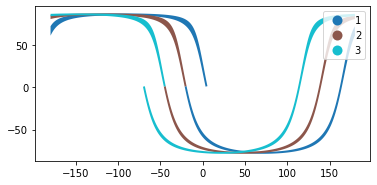

In [18]:
df_dis_p = df_dis.copy()
df_dis_p['relative_orbit_number_s'] = df_dis['relative_orbit_number'].map(str)
df_dis_p.plot(column='relative_orbit_number_s', legend=True)

(-5.0, 5.0)

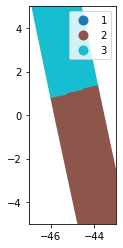

In [19]:
fig, ax = plt.subplots()

df_dis_p.plot(column='relative_orbit_number_s', legend=True, ax=ax)
ax.set_xlim(-47,-43)
ax.set_ylim(-5, 5)

(-5.0, 5.0)

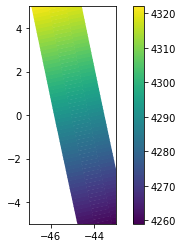

In [20]:
fig, ax = plt.subplots()

df[df['relative_orbit_number'].isin([1, 2, 3])].cx[-48:-43, -5:5].plot(column='burst_id', legend=True, ax=ax)
ax.set_xlim(-47,-43)
ax.set_ylim(-5, 5)

(-5.0, 5.0)

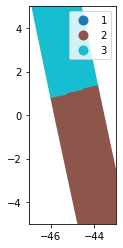

In [21]:
fig, ax = plt.subplots()

df_dis_p.plot(column='relative_orbit_number_s', legend=True, ax=ax)
ax.set_xlim(-47,-43)
ax.set_ylim(-5, 5)

(-5.0, 5.0)

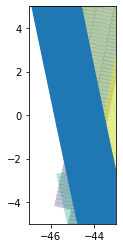

In [22]:
fig, ax = plt.subplots()
s = np.s_[-45:-43,-5: 5]
df.cx[s].plot(column='relative_orbit_number', alpha=.3, ax= ax)
df_dis_p.cx[s].plot(ax=ax)

ax.set_xlim(-47,-43)
ax.set_ylim(-5, 5)

# Dateline Issues

They are disconnected polygons across the polygon that are joined. It may be beneficial to join these.

In [23]:
buffer = 5

In [24]:
ind = df.GEOMETRY.map(lambda geo: geo.geom_type == 'Polygon')
ind.size, ind.sum()

(1127661, 0)

In [25]:
df_dateline = df.cx[:-180 + buffer,:]

<AxesSubplot:>

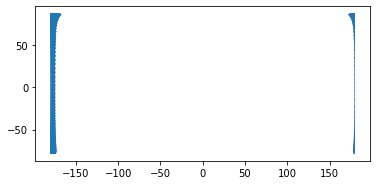

In [26]:
df_dateline.plot()

How we can fix it. Basically explode along the dateline. Might not be the most elegant, but gets the job done.

In [27]:
df_dateline_l = df_dateline.copy()
df_dateline_r = df_dateline.copy()

geo_l = df_dateline.translate(xoff=-360).buffer(1e-7)
df_dateline_l.geometry = df_dateline.geometry.union(geo_l)
df_dateline_l_f = df_dateline_l.dissolve(by='OGC_FID', aggfunc='first').explode(index_parts=False)
df_dateline_l_f = df_dateline_l_f.cx[-180- 80:-180 + buffer, :].reset_index(drop=False)

geo_r = df_dateline.translate(xoff=360).buffer(1e-7)
df_dateline_r.geometry = df_dateline.geometry.union(geo_r)
df_dateline_r_f = df_dateline_r.dissolve(by='OGC_FID', aggfunc='first').explode(index_parts=False)
df_dateline_r_f = df_dateline_r_f.cx[180 - buffer: 180 + 80, :].reset_index(drop=False)

In [28]:
df_dateline_r_f.head()

,OGC_FID,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass,GEOMETRY
0,1818,606,IW3,1,1672.966389,DESCENDING,"POLYGON Z ((188.265 77.815 0.000, 188.265 77.8..."
1,1821,607,IW3,1,1675.724662,DESCENDING,"POLYGON Z ((188.034 77.657 0.000, 188.034 77.6..."
2,1824,608,IW3,1,1678.482935,DESCENDING,"POLYGON Z ((187.813 77.497 0.000, 187.813 77.4..."
3,1827,609,IW3,1,1681.241208,DESCENDING,"POLYGON Z ((187.592 77.338 0.000, 187.592 77.3..."
4,1830,610,IW3,1,1683.999481,DESCENDING,"POLYGON Z ((187.376 77.179 0.000, 187.376 77.1..."


<AxesSubplot:>

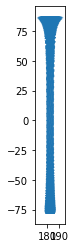

In [29]:
df_dateline_r_f.plot()

<AxesSubplot:>

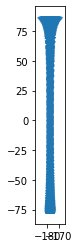

In [30]:
df_dateline_l_f.plot()

In [31]:
OGC_FIDs_l = df_dateline_l_f.OGC_FID.tolist()
OGC_FIDs_r = df_dateline_r_f.OGC_FID.tolist()

In [32]:
df_fixed = df[~df.OGC_FID.isin(OGC_FIDs_l + OGC_FIDs_r)].explode(index_parts=False)
df_fixed = pd.concat([df_fixed, df_dateline_r_f, df_dateline_l_f], axis=0)
df_fixed.head()

,OGC_FID,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass,GEOMETRY
0,1,1,IW1,1,2.301015,ASCENDING,"POLYGON Z ((3.36758 0.75322 0.00000, 3.76300 0..."
1,2,1,IW2,1,3.133218,ASCENDING,"POLYGON Z ((4.09178 0.97402 0.00000, 4.50253 1..."
2,3,1,IW3,1,4.211255,ASCENDING,"POLYGON Z ((4.85545 1.19200 0.00000, 5.21485 1..."
3,4,2,IW1,1,5.059288,ASCENDING,"POLYGON Z ((3.33269 0.92005 0.00000, 3.72810 1..."
4,5,2,IW2,1,5.891491,ASCENDING,"POLYGON Z ((4.05690 1.14071 0.00000, 4.46767 1..."
